In [2]:
import confirm.outlaw.nb_util as nb_util
nb_util.setup_nb()

import pickle
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
# Run on CPU because a concurrent process is probably running on GPU.
jax.config.update('jax_platform_name', 'cpu')

import confirm.mini_imprint.lewis_drivers as lts
from confirm.lewislib import lewis

import adastate
from criterion import Criterion
from diagnostics import lamstar_histogram

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# typeI_sum = batched_rej(
#     sim_sizes,
#     (np.full(sim_sizes.shape[0], overall_cv),
#     g.theta_tiles,
#     g.null_truth,),
#     unifs,
#     unifs_order,
# )

# savedata = [
#     g,
#     sim_sizes,
#     bootstrap_cvs,
#     typeI_sum,
#     hob_upper,
#     pointwise_target_alpha
# ]
# with open(f"{name}/final.pkl", "wb") as f:
#     pickle.dump(savedata, f)

# # Calculate actual type I errors?
# typeI_est, typeI_CI = binomial.zero_order_bound(
#     typeI_sum, sim_sizes, delta_validate, 1.0
# )
# typeI_bound = typeI_est + typeI_CI

# hob_upper = binomial.holder_odi_bound(
#     typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
# )
# sim_cost = typeI_CI
# hob_empirical_cost = hob_upper - typeI_bound
# worst_idx = np.argmax(typeI_est)
# worst_tile = g.theta_tiles[worst_idx]
# typeI_est[worst_idx], worst_tile
# worst_cv_idx = np.argmin(sim_cvs)
# typeI_est[worst_cv_idx], sim_cvs[worst_cv_idx], g.theta_tiles[worst_cv_idx], pointwise_target_alpha[worst_cv_idx]
# plt.hist(typeI_est, bins=np.linspace(0.02,0.025, 100))
# plt.show()

# theta_0 = np.array([-1.0, -1.0, -1.0])      # sim point
# v = 0.1 * np.ones(theta_0.shape[0])     # displacement
# f0 = 0.01                               # Type I Error at theta_0
# fwd_solver = ehbound.ForwardQCPSolver(n=n_arm_samples)
# q_opt = fwd_solver.solve(theta_0=theta_0, v=v, a=f0) # optimal q
# ehbound.q_holder_bound_fwd(q_opt, n_arm_samples, theta_0, v, f0)

: 

In [3]:
name = '4d_full'
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}
lei_obj = lewis.Lewis45(**params)

In [5]:
with open(f"./{name}/data_params.pkl", "rb") as f:
    P, D = pickle.load(f)
load_iter = 'latest'
S, load_iter, fn = adastate.load(name, load_iter)

loading checkpoint 4d_full/870.pkl


In [ ]:
S.db.data.dtype

: 

In [11]:
S.B_lam.min(axis=0)

array([0.02606544, 0.05251814, 0.03002989, 0.0410103 , 0.05790379, 0.05208904, 0.05505504,
       0.04352877, 0.04846264, 0.04710424, 0.0477612 , 0.05056262, 0.05523033, 0.04159709,
       0.04561263, 0.05100475, 0.04746837, 0.04306115, 0.03158544, 0.05153337, 0.04270624,
       0.03392299, 0.04859631, 0.04313213, 0.04495298, 0.03734053, 0.05355277, 0.04917241,
       0.04070365, 0.04018301, 0.03782928, 0.05067006, 0.04268644, 0.05345094, 0.04948373,
       0.0480767 , 0.05188984, 0.04235974, 0.05315839, 0.04890179, 0.0291527 , 0.0423447 ,
       0.04270624, 0.03961357, 0.04410122, 0.05147359, 0.03721501, 0.05752413, 0.05106737,
       0.04564083], dtype=float32)

In [15]:
S.B_lam.argmin(axis=0)

array([   13631,  6084714,    13631,    51901,    67195,    53033,  5868585,    47161,   255024,
          79624,  1190203,    55661,       10,   269173,    47239,   145283,    28186,    29223,
            536,    69948,    11912,   111701,  1099424,     4744,    50038,   111694,   392907,
        5318112,   117506,    79250,   173529,    56610,    32761,    44745,  3388401,   171164,
         117280,    33341,  4705361,   124503,   113093,    55273,    11912,    26887,    52908,
        5251332,   244588, 10795777,   529307,   335215])

In [16]:
S.alpha0[S.B_lam.argmin(axis=0)]

array([0.01103222, 0.02059794, 0.01103222, 0.01121366, 0.01102832, 0.01131879, 0.02383826,
       0.01096793, 0.01678357, 0.01158825, 0.01709127, 0.0116747 , 0.01111139, 0.01697302,
       0.01095746, 0.01090779, 0.01104271, 0.01105824, 0.01101604, 0.01110022, 0.01113131,
       0.01109197, 0.02065237, 0.01109032, 0.01113768, 0.01104735, 0.01690866, 0.02381841,
       0.01126887, 0.01112858, 0.01108305, 0.01104929, 0.01105163, 0.01107503, 0.02050965,
       0.01702588, 0.01089187, 0.0109352 , 0.02381834, 0.01684059, 0.01098543, 0.01102639,
       0.01113131, 0.01104061, 0.01149361, 0.02269942, 0.01093678, 0.02271575, 0.02384233,
       0.02054708], dtype=float32)

In [17]:
S.sim_sizes[S.B_lam.argmin(axis=0)]

array([2048, 2048, 2048, 2048, 2048, 8192, 4096, 4096, 4096, 2048, 2048, 2048, 2048, 2048, 4096,
       2048, 4096, 2048, 2048, 2048, 4096, 2048, 2048, 2048, 2048, 2048, 2048, 4096, 2048, 2048,
       2048, 4096, 2048, 4096, 2048, 2048, 2048, 2048, 4096, 2048, 2048, 2048, 4096, 2048, 4096,
       2048, 2048, 2048, 4096, 2048])

In [13]:
S.twb_min_lam.min()

0.04846025

In [8]:
S.orig_lam.min()

0.059082072

In [9]:
np.min(S.twb_mean_lam + 3 * (S.twb_max_lam - S.twb_mean_lam))

0.07775803678911476

In [13]:
np.sum(S.twb_min_lam < np.min(S.twb_max_lam)) / 1e6

10.939675

In [4]:
cr = Criterion(lei_obj, P, S, D)

tuning for 2048 simulations with 1 tiles and batch size (1, 16384)
13.504690885543823
0.23038029670715332


In [7]:
S.sim_sizes[cr.dangerous]

array([2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, ..., 2048, 2048, 2048, 2048,
       2048, 2048, 2048, 2048, 2048, 2048])

In [8]:
cr.alpha_cost[cr.dangerous]

array([0.00821412, 0.00821412, 0.00821412, 0.00821412, 0.00821412, 0.00821412, 0.00821412,
       0.00821412, 0.00821412, 0.00821412, ..., 0.00115622, 0.00115668, 0.00116628, 0.00116622,
       0.0011669 , 0.00115634, 0.00115651, 0.00227491, 0.00115646, 0.00116719])

In [9]:
np.sum(cr.impossible_refine_orig)

0

In [10]:
cr.twb_worst_tile_lam_max

0.17853488313860963

In [11]:
cr.twb_worst_tile_lam_min

0.07663923257289554

In [12]:
assert S.twb_max_lam[cr.twb_worst_tile] == np.min(S.twb_max_lam)
assert S.twb_min_lam[cr.twb_worst_tile] == np.min(S.twb_min_lam[cr.ties])

In [13]:
S.alpha0[cr.dangerous]

array([0.01678588, 0.01678588, 0.01678588, 0.01678588, 0.01678588, 0.01678588, 0.01678588,
       0.01678588, 0.01678588, 0.01678588, ..., 0.02384378, 0.02384332, 0.02383372, 0.02383378,
       0.0238331 , 0.02384366, 0.02384349, 0.02272509, 0.02384354, 0.02383281])

In [14]:
S.B_lam[cr.dangerous].min(axis=1)

array([0.05750552, 0.05750552, 0.05750552, 0.05750552, 0.05750552, 0.05750552, 0.05750552,
       0.05750552, 0.05750552, 0.05750552, ..., 0.05136212, 0.0535219 , 0.05489636, 0.05489636,
       0.05499151, 0.05136212, 0.05280642, 0.04995333, 0.05136212, 0.05499151])

In [15]:
twb_B_lamss = S.twb_min_lam[cr.B_lamss_idx]
twb_B_lamss

array([0.06000694, 0.04791931, 0.05147016, 0.05172274, 0.04803345, 0.05005337, 0.04771543,
       0.04704175, 0.04855357, 0.04913729, 0.0511201 , 0.04859293, 0.047038  , 0.04704175,
       0.04910322, 0.0481949 , 0.04787684, 0.05103072, 0.04815925, 0.05122118, 0.05067325,
       0.04753021, 0.05045566, 0.05207906, 0.04798889, 0.04885972, 0.05324594, 0.04704175,
       0.05122177, 0.04797916, 0.04773898, 0.05053985, 0.05866314, 0.04718991, 0.05436781,
       0.04744147, 0.04917576, 0.05187681, 0.04830371, 0.05002562, 0.04949665, 0.04773898,
       0.05036799, 0.04702054, 0.052875  , 0.04935237, 0.05911516, 0.04771543, 0.04855225,
       0.04839694])

In [16]:
S.alpha0[cr.B_lamss_idx]

array([0.01103222, 0.01675478, 0.01107155, 0.01143649, 0.01096799, 0.00446398, 0.01105156,
       0.01096735, 0.01100359, 0.01103717, 0.01141497, 0.01090973, 0.01112883, 0.01096735,
       0.01102832, 0.01120453, 0.01129084, 0.01113582, 0.01096395, 0.01110622, 0.010984  ,
       0.01111216, 0.02068377, 0.01095677, 0.01120882, 0.01107069, 0.01116545, 0.01096735,
       0.01122387, 0.01128056, 0.01114651, 0.01096642, 0.01105163, 0.01121727, 0.02268124,
       0.00456656, 0.01672331, 0.01105765, 0.02382874, 0.01104061, 0.01104203, 0.01119694,
       0.01101606, 0.01095157, 0.01157744, 0.02058731, 0.01093678, 0.01108208, 0.02077701,
       0.0167958 ])

In [17]:
cr.B_lamss

array([0.02606544, 0.04592283, 0.02734657, 0.03045288, 0.04874856, 0.03685173, 0.04985145,
       0.03575315, 0.04531893, 0.0325263 , 0.03973327, 0.04524111, 0.04997238, 0.03856918,
       0.03566392, 0.04239779, 0.04257397, 0.03922839, 0.01755381, 0.0436527 , 0.03082933,
       0.03340146, 0.04419721, 0.04105984, 0.03743935, 0.02752495, 0.04645401, 0.03856918,
       0.03719655, 0.03809414, 0.03435018, 0.03368752, 0.04268644, 0.04094665, 0.04649773,
       0.03964863, 0.04917576, 0.04100902, 0.04904486, 0.04679737, 0.02747119, 0.04169126,
       0.02892672, 0.03594546, 0.04389503, 0.04228562, 0.037215  , 0.04821303, 0.04828925,
       0.04427942])

In [18]:
def find_queue_position(lam):
    return np.sum(cr.inflated_min_lam[:, None] < lam[None, :], axis=0)

In [19]:
S.twb_min_lam[np.argsort(S.orig_lam)[0]]

0.047245535862146165

In [21]:
up_next = np.argsort(S.orig_lam)[:10000]
S.alpha0[up_next].max(), S.sim_sizes[up_next].max()

(0.023861390166685318, 16384)

In [25]:
sorted_ordering = np.sort(cr.inflated_min_lam)
overall_ordering = np.argsort(S.orig_lam)[:1000]
query = cr.inflated_min_lam[overall_ordering]
overall_priority = jnp.searchsorted(sorted_ordering, query)
print("overall driver priority", overall_priority)


overall driver priority [ 132532  132532  132532  132532  132532  132532  132532  132532   77343   77343   77343   77343
   70800   70800   70800   70800  299698  150426  299698  150426  150426  288976  299698  288976
  339296  299698  288976   77343  288976  150426   77343  339296   51025  299698  288976  150426
  150426  150426   51025  339296  299698  288976  150426  150426  339296  339296  150426   51025
  299698  288976  150426  150426  150426  339296   51025  299698  339296  288976  150426  150426
   77343  150426  133234   51025  339296   77343  133234   51025  133234  150426   51025  150426
  150426  150426  133234   51025  101646  101646  101646  101646  101646  101646  101646  101646
  101646  101646  101646  101646  101646  101646  101646  101646  299698  288976  288976  299698
  288976  299698  288976  299698 1316727 1316727 1316727 1316727  289232   86950   51889   51889
   51889  101646  101646   86950   51889  289232  289232  101646   86950  101646  101646  101646
   869

In [23]:
np.maximum.accumulate(overall_priority)

array([ 132532,  132532,  132532,  132532,  132532,  132532,  132532,  132532,  132532,  132532,
        132532,  132532,  132532,  132532,  132532,  132532,  299698,  299698,  299698,  299698,
        299698,  299698,  299698,  299698,  339296,  339296,  339296,  339296,  339296,  339296,
        339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,
        339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,
        339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,
        339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,
        339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,
        339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,
        339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,  339296,
       1316727, 1316727, 13167

In [28]:
print('overall_lam', cr.overall_lam)
print('bias driver priority', find_queue_position(twb_B_lamss))
B_min = S.B_lam.min(axis=1)
bias_bad = B_min < cr.overall_lam
print('n bias bad', np.sum(bias_bad))
n_critical = np.sum((S.orig_lam < cr.overall_lam + 0.01))
n_loose = np.sum(
    (S.orig_lam < cr.overall_lam + 0.01)
    & (P.alpha_target - S.alpha0 > P.grid_target)
)
print(f"number of tiles near critical: {n_critical}")
print(f"    and with loose bounds {n_loose}")
# for i in range(10):
#     dangerous = np.sum(cr.inflated_min_lam[bias_bad] < cr.overall_lam)
#     collateral = np.sum(cr.inflated_min_lam < cr.overall_lam)
#     print(f'inflation factor {i}')
#     print(f'    dangerous tiles caught: {dangerous}')
#     print(f'    collateral tiles caught: {collateral}')

print('lambda**B', cr.B_lamss)
total_effort = np.sum(S.sim_sizes)
for K in np.unique(S.sim_sizes):
    sel = S.sim_sizes == K
    count = np.sum(sel)
    print(f"K={K}:")
    print(f'    count={count / 1e6:.3f}m')
    print(f'    lambda**B[K]={S.B_lam[sel].min(axis=0)}')
    print(f'    min lambda*B[K]={np.min(S.B_lam[sel].min(axis=1)):.4f}')
    print(f'    min lambda*b[K]={np.min(S.twb_min_lam):.4f}')
    effort = K * count / total_effort
    print(f'    % effort={100 * effort:.4f}') 

overall_lam 0.05317818198849435
bias driver priority [8193453  651531 3296019 3499662  688083 2159655  560814   47465 1036245 1333511 3036702 1046953
   47381   47465 1316727  781230  638106 2991672  747040 3068271 2557473  401822 2492422 3678127
  674388 1202580 4992120   47465 3068415  671547  564664 2516959 7703518  101646 5802774  363642
 1373447 3572415  815009 2146809 1509096  564664 2434699   11829 4421287 1459562 7861144  560814
 1031469  969975]
n bias bad 2884093
number of tiles near critical: 508768
    and with loose bounds 85175
lambda**B [0.02606544 0.04592283 0.02734657 0.03045288 0.04874856 0.03685173 0.04985145 0.03575315 0.04531893
 0.0325263  0.03973327 0.04524111 0.04997238 0.03856918 0.03566392 0.04239779 0.04257397 0.03922839
 0.01755381 0.0436527  0.03082933 0.03340146 0.04419721 0.04105984 0.03743935 0.02752495 0.04645401
 0.03856918 0.03719655 0.03809414 0.03435018 0.03368752 0.04268644 0.04094665 0.04649773 0.03964863
 0.04917576 0.04100902 0.04904486 0.046797

MemoryError: Unable to allocate 6.64 GiB for an array with shape (17811576, 50) and data type float64

In [29]:
S.db.data[cr.twb_worst_tile, -3:]

array([0.0473162 , 0.05721522, 0.0630007 ])

In [31]:
S.alpha0[S.twb_min_lam < 0.047]

array([0.02269475, 0.02269499, 0.02269458, 0.02269483, 0.02269475, 0.02269499, 0.02269458,
       0.02269483, 0.02269475, 0.02269499, ..., 0.02383695, 0.02383702, 0.02383709, 0.02383716,
       0.02383723, 0.0238373 , 0.02383666, 0.02383673, 0.02383666, 0.02383673])

In [32]:
S.twb_min_lam[np.argsort(S.orig_lam)[:1000]]

array([0.04724554, 0.04724554, 0.04724554, 0.04724554, 0.04724554, 0.04724554, 0.04724554,
       0.04724554, 0.04711488, 0.04711488, 0.04711488, 0.04711488, 0.04710391, 0.04710391,
       0.04710391, 0.04710391, 0.04734873, 0.04728876, 0.04734873, 0.04728876, 0.04728876,
       0.04732693, 0.04734873, 0.04732693, 0.04741789, 0.04734873, 0.04732693, 0.04711488,
       0.04732693, 0.04728876, 0.04711488, 0.04741789, 0.04705542, 0.04734873, 0.04732693,
       0.04728876, 0.04728876, 0.04728876, 0.04705542, 0.04741789, 0.04734873, 0.04732693,
       0.04728876, 0.04728876, 0.04741789, 0.04741789, 0.04728876, 0.04705542, 0.04734873,
       0.04732693, 0.04728876, 0.04728876, 0.04728876, 0.04741789, 0.04705542, 0.04734873,
       0.04741789, 0.04732693, 0.04728876, 0.04728876, 0.04711488, 0.04728876, 0.04725251,
       0.04705542, 0.04741789, 0.04711488, 0.04725251, 0.04705542, 0.04725251, 0.04728876,
       0.04705542, 0.04728876, 0.04728876, 0.04728876, 0.04725251, 0.04705542, 0.04718991,

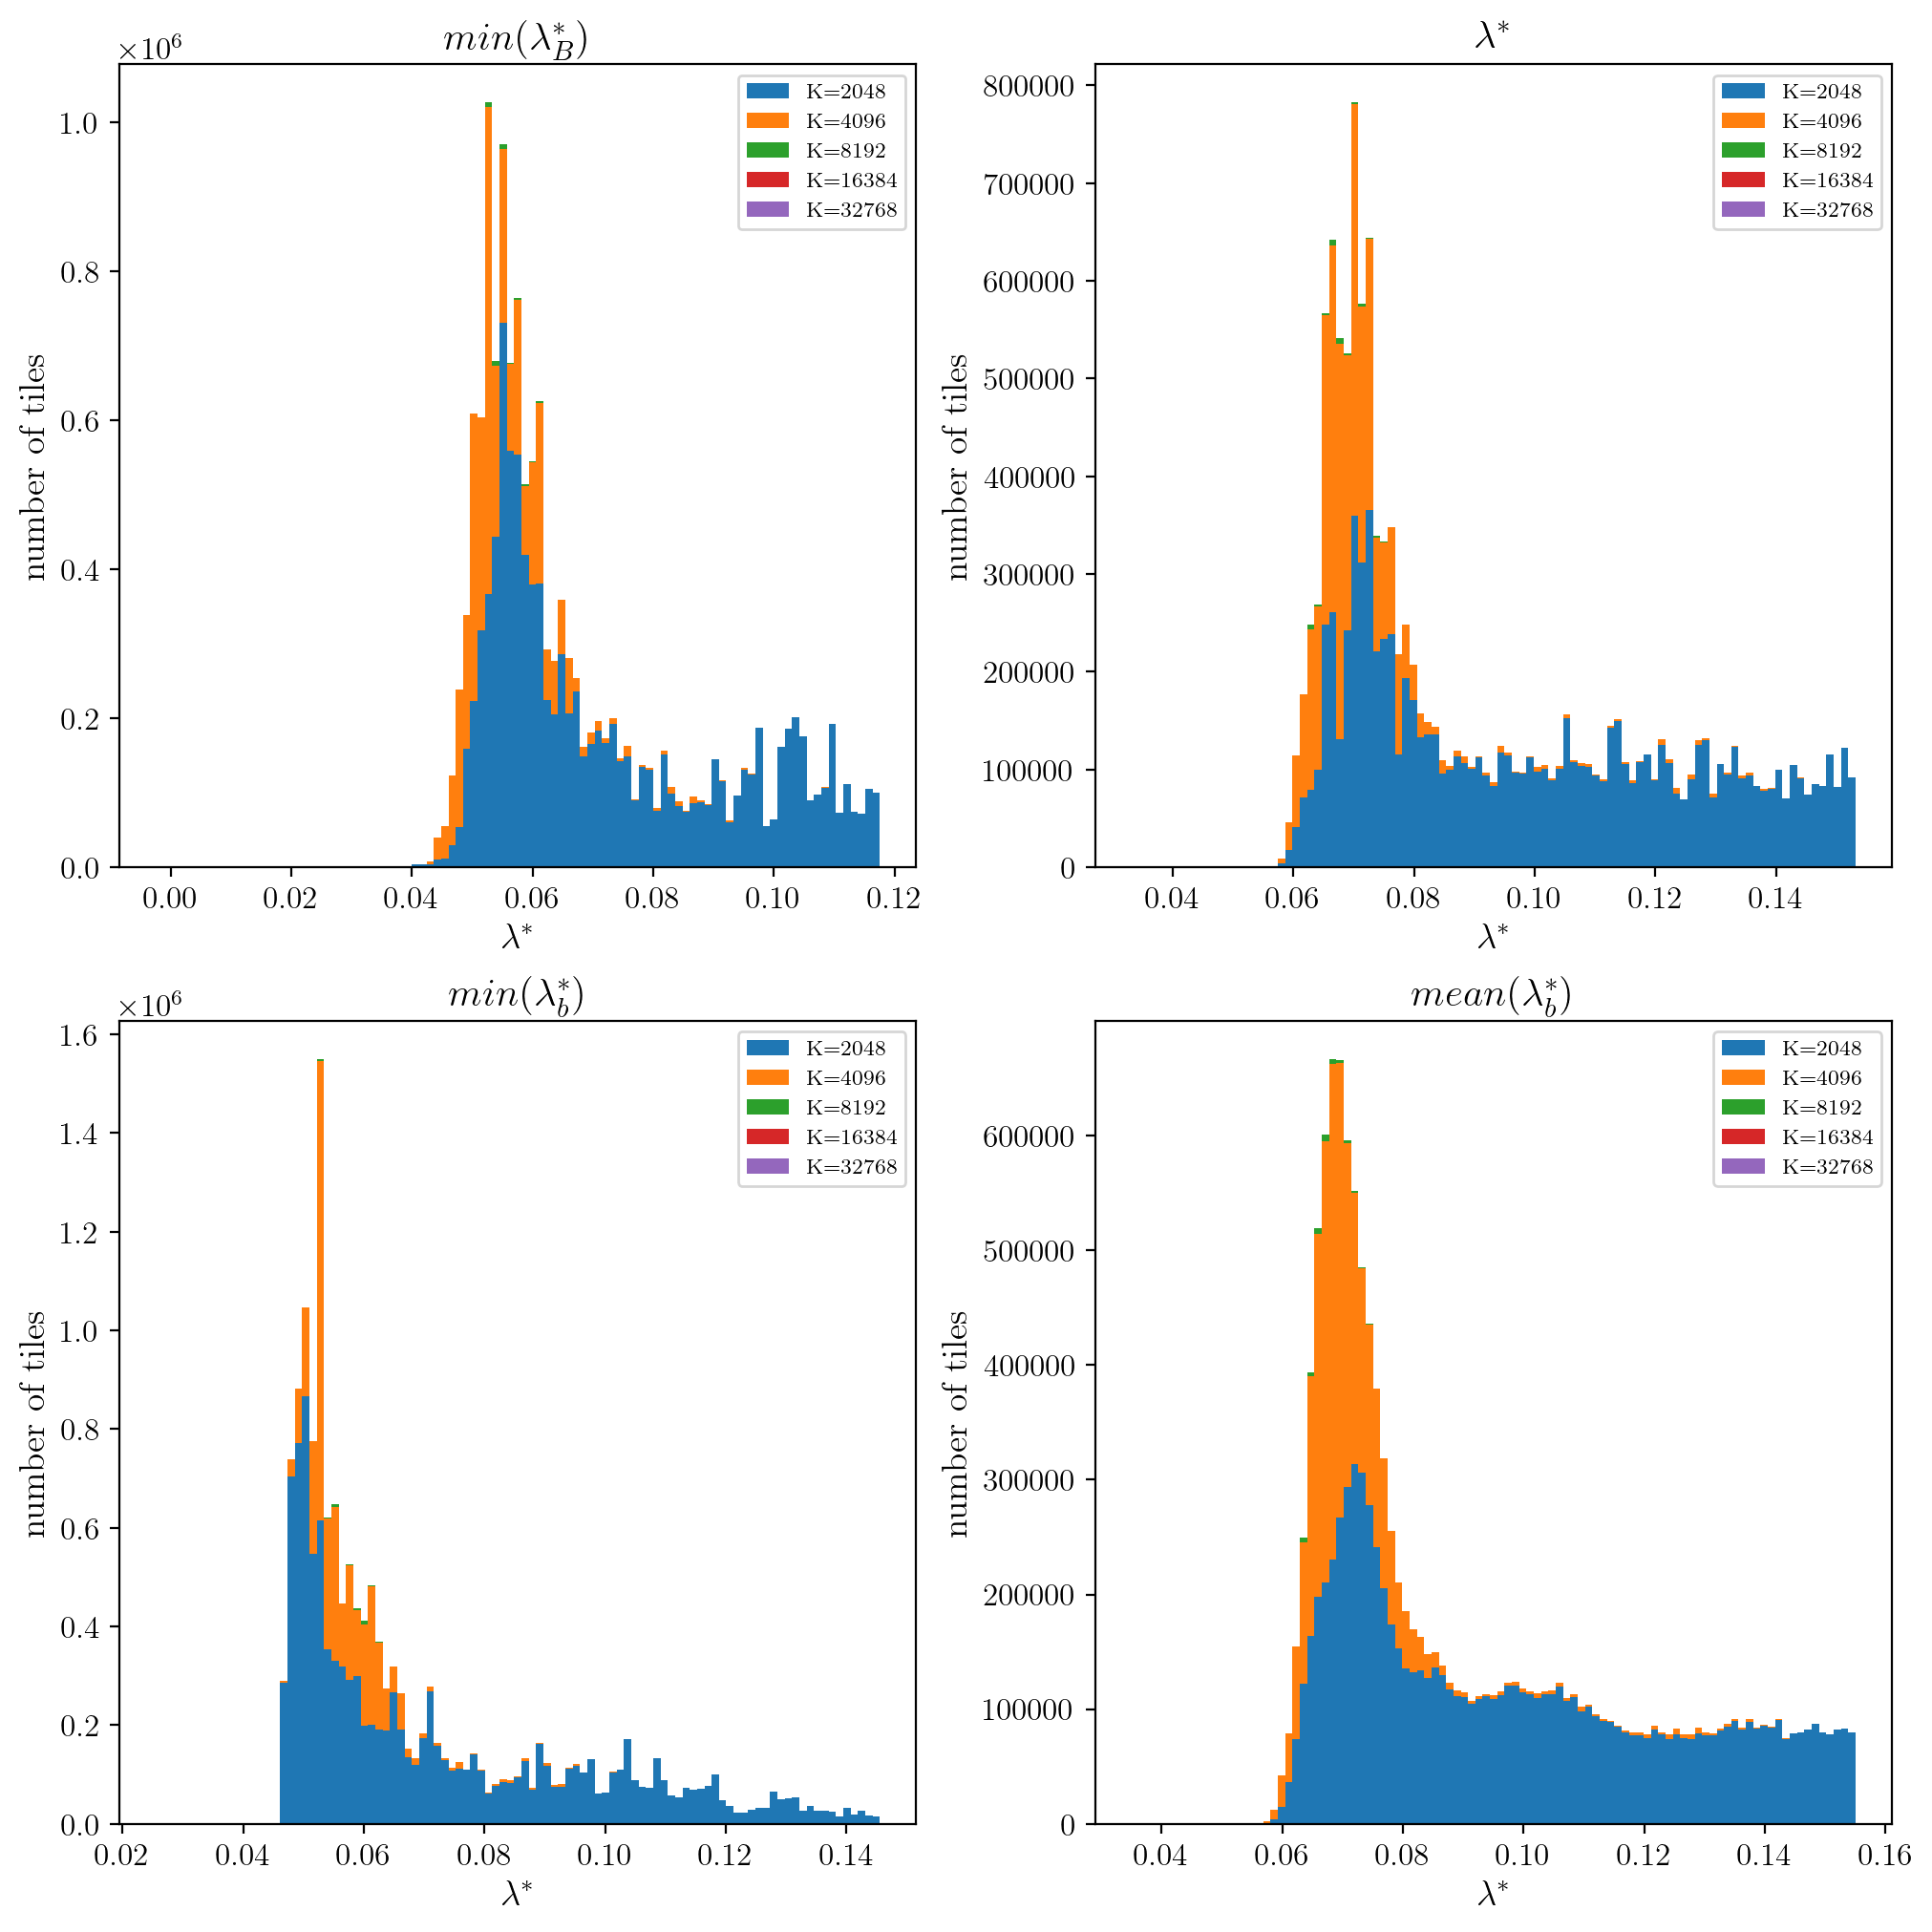

In [34]:
plt.figure(figsize=(10, 10), constrained_layout=True)
plt.subplot(2,2, 1)
plt.title('$min(\lambda^*_B)$')
lamstar_histogram(S.B_lam.min(axis=1), S.sim_sizes)
for i, (field, title) in enumerate([(S.orig_lam, '$\lambda^{*}$'), (S.twb_min_lam, '$min(\lambda^*_b)$'), (S.twb_mean_lam, '$mean(\lambda^*_b)$')]):
    plt.subplot(2,2,i + 2)
    plt.title(title)
    lamstar_histogram(field, S.sim_sizes)
plt.show()

## Resimulation

In [9]:
import pandas as pd
friends = np.where(bootstrap_cvs[:,0] < 0.045)[0]
print(pd.DataFrame(sim_sizes[friends]).describe())
print(pd.DataFrame(pointwise_target_alpha[friends]).describe())

                  0
count  34476.000000
mean    1160.053370
std      564.423262
min     1000.000000
25%     1000.000000
50%     1000.000000
75%     1000.000000
max     8000.000000
                  0
count  34476.000000
mean       0.006419
std        0.002901
min        0.000561
25%        0.004503
50%        0.004715
75%        0.010948
max        0.011460


In [10]:
seed = 0
src_key = jax.random.PRNGKey(seed)
key1, key2, key3 = jax.random.split(src_key, 3)

unifs = jax.random.uniform(key=key1, shape=(adap.max_sim_size,) + lei_obj.unifs_shape(), dtype=jnp.float32)
unifs_order = jnp.arange(0, unifs.shape[1])
nB_global = 30
nB_tile = 40
bootstrap_idxs = {
    K: jnp.concatenate((
        jnp.arange(K)[None, :],
        jax.random.choice(key2, K, shape=(nB_global, K), replace=True),
        jax.random.choice(key3, K, shape=(nB_tile, K), replace=True)
    )).astype(jnp.int32)
    for K in (adap.init_K * 2 ** np.arange(0, adap.n_sim_double + 1))
}

In [11]:
print('hi')

hi


In [12]:
which = friends[:4]
lamstar = lts.bootstrap_tune_runner(
    lei_obj,
    sim_sizes[which],
    pointwise_target_alpha[which],
    g.theta_tiles[which],
    g.null_truth[which],
    unifs,
    bootstrap_idxs,
    unifs_order,
    grid_batch_size=4
)

tuning for 1000 simulations with 3 tiles and batch size (4, 1000)


In [13]:
stats = np.random.rand(3, 1000)

In [38]:
from confirm.lewislib import batch
grid_batch_size=4
def printer(x, y, z):
    print(x.shape, y.shape, z.shape)
    return 0
tunev = jax.jit(jax.vmap(jax.vmap(lts.tune, in_axes=(None, 0, None)), in_axes=(0, None, 0)))
batched_tune = batch.batch(
    batch.batch(tunev, 10, in_axes=(None, 0, None), out_axes=(1,)),
    grid_batch_size, in_axes=(0, None, 0)
)
batched_tune(stats, bootstrap_idxs[1000], np.array([0.025, 0.025, 0.025])).shape

(3, 71)

In [31]:
bootstrap_idxs[1000].shape

(71, 1000)

In [28]:
batch.batch(lts.tunev, 10, in_axes=(None, 0, None))(stats[0], bootstrap_idxs[1000], 0.025).shape

(71,)

In [36]:
tunev(stats, bootstrap_idxs[1000], np.full(3, 0.025)).shape

(3, 71)

In [23]:
bootstrap_idxs[1000].shape

(71, 1000)

## Look at the worst case from bootstrap group 1.

- $\lambda^*$ is the tile-wise threshold
- $\lambda^{**}$ is the global minimum threshold.
-

- TODO: what is the right notation for the different $\lambda$??

These are points that will drive down $\lambda^*_B$

In [4]:
bootstrap_mins2 = bootstrap_cvs[:,1:-2].min(axis=1)
trixy = np.argsort(bootstrap_mins2)[:100]
print(bootstrap_mins2[trixy])
print(bootstrap_cvs[trixy, 0])
print(bootstrap_cvs[trixy, -2])
print(bootstrap_cvs[trixy, -1])

[0.         0.         0.         0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.         0.         0.         0.00514508
 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508
 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508
 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00859748 0.00859748 0.01154261 0.01154261
 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261
 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261
 0.01154261 0.01154261 0.0115426

In [5]:
trixy = bootstrap_cvs[:, :-2].argmin(axis=0)
print(bootstrap_mins2[trixy])
print(bootstrap_cvs[trixy, 0])
print(bootstrap_cvs[trixy, -2])
print(bootstrap_cvs[trixy, -1])

[0.04354637 0.04354637 0.02789495 0.01429929 0.0269085  0.00859748 0.         0.04354637 0.02218252
 0.0393493  0.        ]
[0.04354637 0.04354637 0.08347789 0.12302681 0.07766329 0.11524351 0.10524046 0.04354637 0.20173591
 0.07177567 0.08327259]
[0.04354637 0.04354637 0.06162066 0.0683219  0.05937429 0.05981035 0.06252524 0.04354637 0.07761585
 0.0587158  0.05974139]
[0.04354637 0.04354637 0.09433731 0.11718224 0.07398375 0.23521529 0.1059908  0.04354637 0.22964628
 0.07535339 0.12694353]


In [6]:
pointwise_target_alpha[trixy], sim_sizes[trixy], g.radii[g.grid_pt_idx[trixy]]

(array([0.02050906, 0.02050906, 0.01170158, 0.00495953, 0.01116916, 0.00455338, 0.00462812,
        0.02050906, 0.00494191, 0.01693105, 0.00451102]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]),
 array([[0.00390625, 0.00390625, 0.00390625, 0.00390625],
        [0.00390625, 0.00390625, 0.00390625, 0.00390625],
        [0.015625  , 0.015625  , 0.015625  , 0.015625  ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.015625  , 0.015625  , 0.015625  , 0.015625  ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.00390625, 0.00390625, 0.00390625, 0.00390625],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   ]]))

In [12]:
import scipy.spatial
tree = scipy.spatial.KDTree(g.theta_tiles)

In [14]:
worst_tile_idx = np.argmin(bootstrap_cvs[:,0])
worst_tile = g.theta_tiles[worst_tile_idx]

slice_pt = worst_tile
plot_dims = [0, 1]
unplot_dims = list(set(range(g.d)) - set(plot_dims))

slicex = [-1, 1]
slicey = [-1, 1]
nx = ny = 100
xvs = np.linspace(*slicex, nx)
yvs = np.linspace(*slicey, ny)
grid = np.stack(np.meshgrid(xvs, yvs, indexing='ij'), axis=-1)
full_grid = np.empty((nx * ny, g.d))
full_grid[:, plot_dims] = grid.reshape(-1, 2)
full_grid[:, unplot_dims] = slice_pt[unplot_dims]

In [20]:
closest_idx[1]

array([ 127690,  127687,  127687,  127687,  127687,  127687,  127687,  127687,  127686,  127686,
       ...,   27258,   27258,   27258, 1102285, 1102285, 1102281,  308063, 3362909, 3362909,
       3382399])

In [15]:
closest_idx = tree.query(full_grid)
closest_idx

(array([0.87117257, 0.85748238, 0.84260622, 0.82795573, 0.81354311, 0.79938122, 0.78548363,
        0.7718646 , 0.75713012, 0.74239052, ..., 0.04222419, 0.03402861, 0.03673218, 0.02316994,
        0.02160324, 0.02009795, 0.02419237, 0.01947861, 0.01010055, 0.01235265]),
 array([ 127690,  127687,  127687,  127687,  127687,  127687,  127687,  127687,  127686,  127686,
        ...,   27258,   27258,   27258, 1102285, 1102285, 1102281,  308063, 3362909, 3362909,
        3382399]))

In [ ]:
eval_pts = 

20105


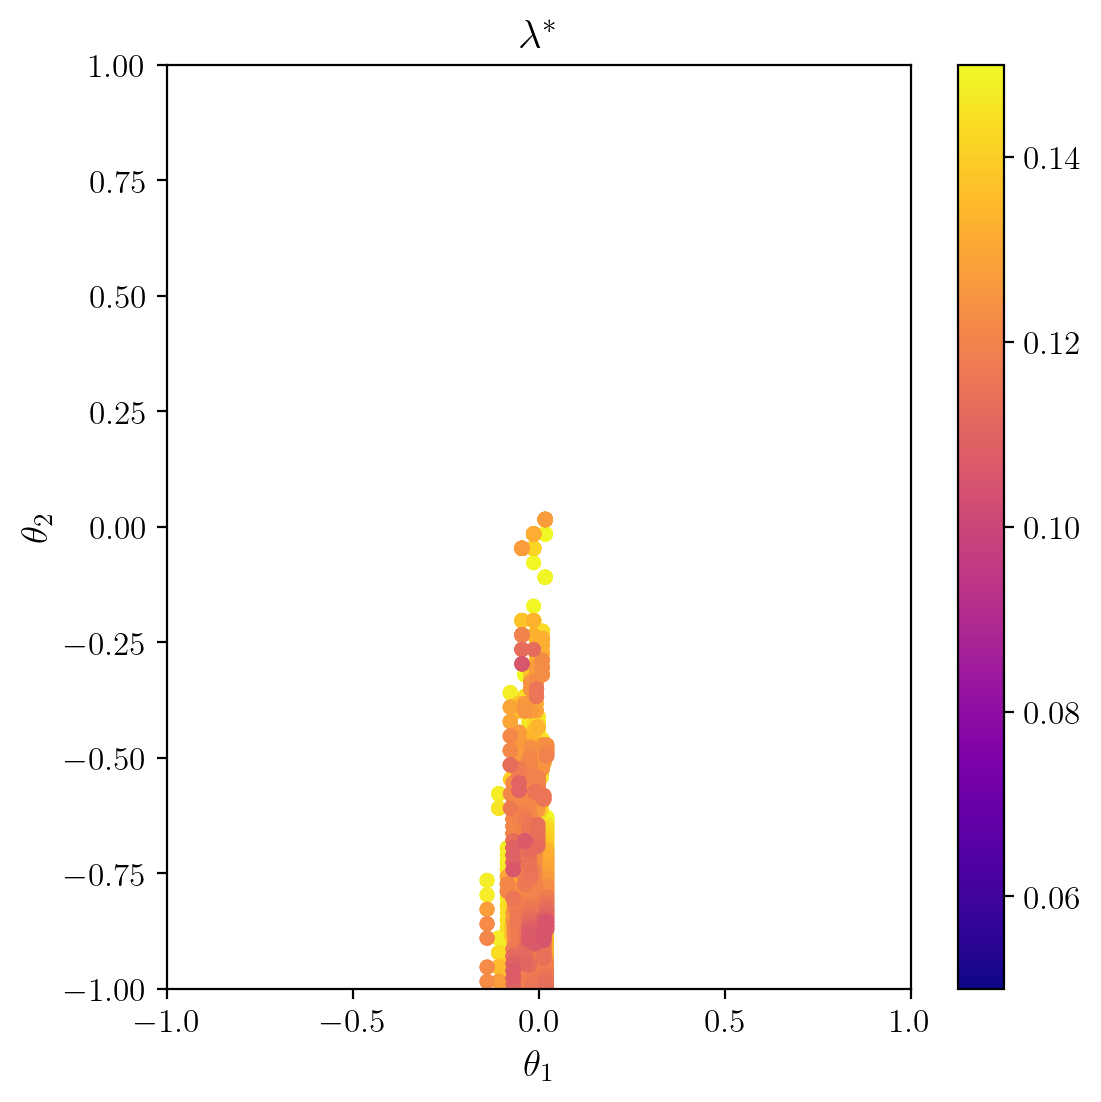

20282


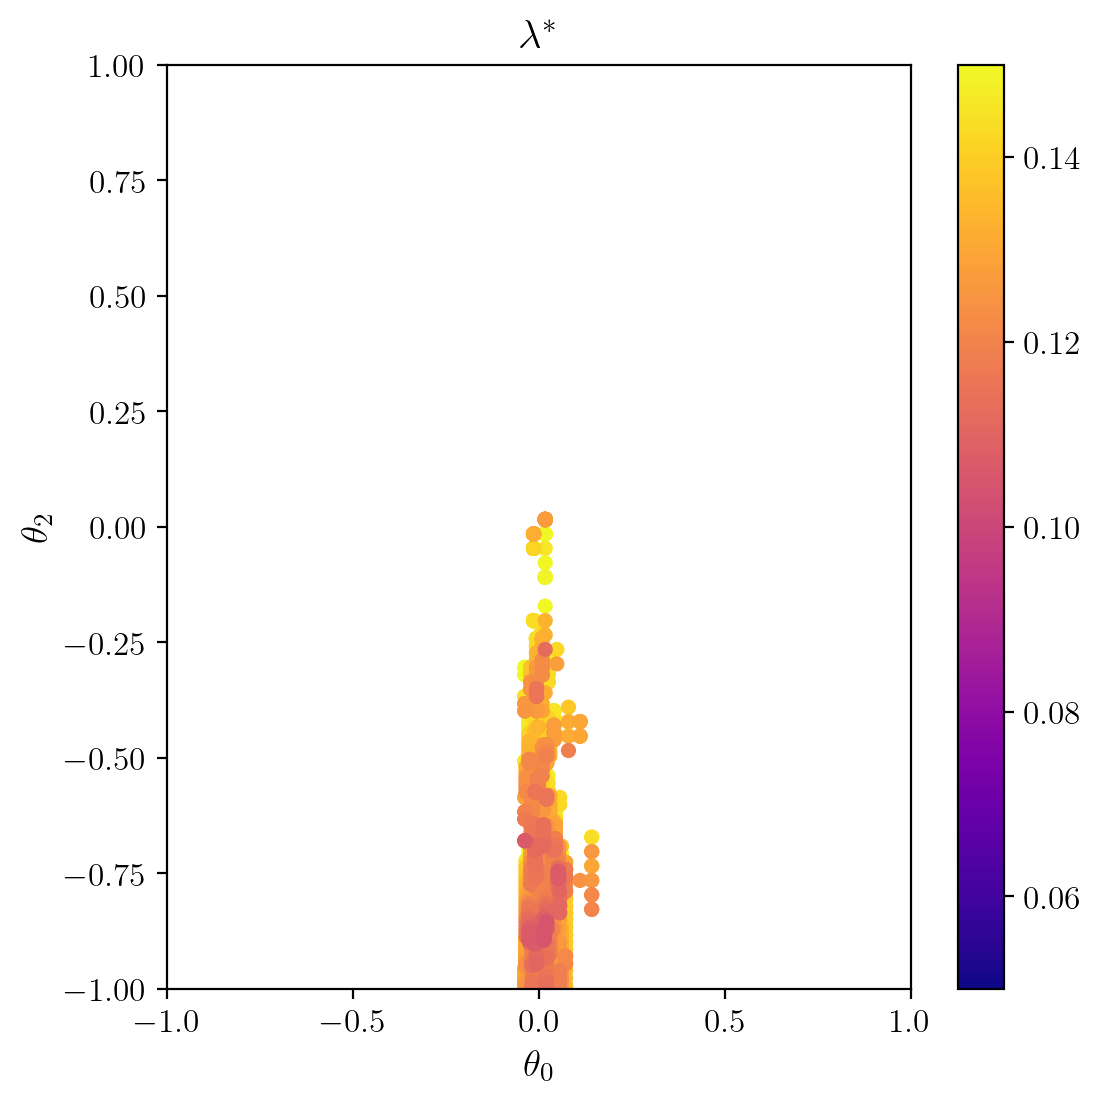

In [11]:
# worst_tile_idx = np.argmin(bootstrap_cvs[:,0])
# worst_tile = g.theta_tiles[worst_tile_idx]
# # def pandemonium(field):
# field = bootstrap_cvs[:,0]
# # for unplot_set in [{0, 1}, {1, 2}]:
# for unplot_set in [{0}, {1}]:
#     plot = list(set(range(n_arms)) - unplot_set)
#     unplot = list(unplot_set)
#     axis_slice = np.all(np.abs(g.theta_tiles[:, unplot] - (-0.01)) < 0.03, axis=-1)
#     select = np.where(axis_slice & (field < 0.15))[0]

#     ordered_select = select[np.argsort(field[select])[::-1]]
#     print(ordered_select.shape[0])

#     plt.figure(figsize=(6, 6))
#     plt.title(r"$\lambda^{*}$")
#     plt.scatter(
#         g.theta_tiles[ordered_select, plot[0]],
#         g.theta_tiles[ordered_select, plot[1]],
#         c=field[ordered_select],
#         vmin=0.05,
#         vmax=0.15,
#         s=20,
#     )
#     plt.xlim([-1, 1])
#     plt.ylim([-1, 1])
#     plt.colorbar()
#     plt.xlabel(f"$\\theta_{plot[0]}$")
#     plt.ylabel(f"$\\theta_{plot[1]}$")
#     plt.show()